**Importing Basic Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

**Exploring Dataset**

In [2]:

# Step 1: Load the dataset
df = pd.read_csv('yahoo_stock.csv', parse_dates=['Date'])

# Step 2: Use 'Date' as the index
df.set_index('Date', inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-11-23 to 2020-11-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1825 non-null   float64
 1   Low        1825 non-null   float64
 2   Open       1825 non-null   float64
 3   Close      1825 non-null   float64
 4   Volume     1825 non-null   float64
 5   Adj Close  1825 non-null   float64
dtypes: float64(6)
memory usage: 99.8 KB


**Feature Exploration**:
                       is a crucial step in the data analysis process where analysts investigate individual variables (features) in a dataset to understand their characteristics, distributions, and relationships with other variables. This step helps uncover important patterns, detect anomalies, and evaluate the relevance of each feature for predictive modeling. It often involves visualizing data through plots, calculating descriptive statistics (like mean, median, and standard deviation), and examining trends over time if the data is sequential. Effective feature exploration allows data scientists to make informed decisions about feature selection, engineering, and transformation, ultimately improving the performance and interpretability of machine learning models.

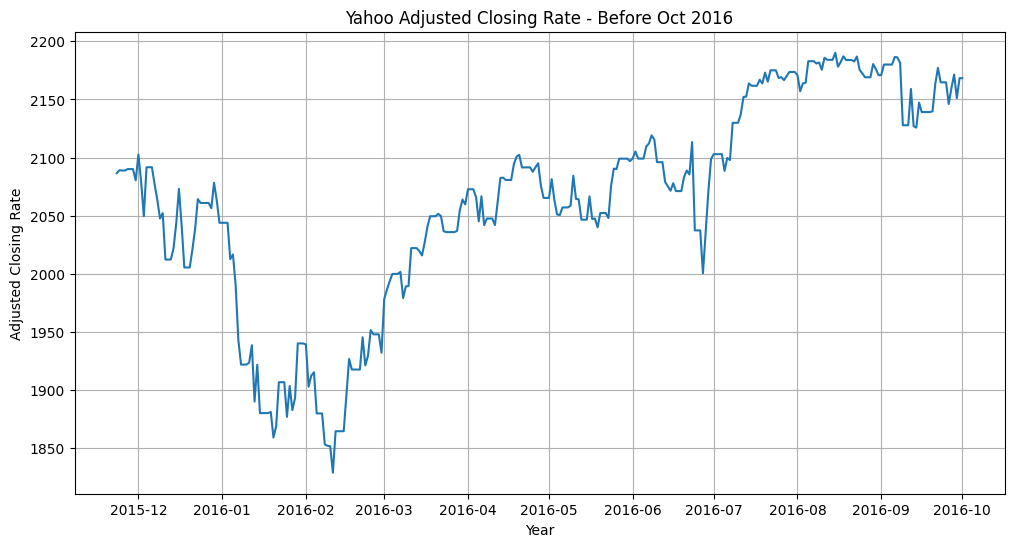

In [3]:

data = pd.DataFrame({'Close_Adj': df['Adj Close']})

date_thresh = datetime.strptime('2016-10-01', "%Y-%m-%d").date()

data_train = data[:str(date_thresh)]
data_test = data[str(date_thresh):]

plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['Close_Adj'], label='Train')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Yahoo Adjusted Closing Rate - Before Oct 2016')
plt.grid(True)
plt.show()


**Insights**

Early 2016: The stock price dropped a lot the market was going down.

February 2016: The lowest point in the graph not a good time for investors.

After February: The price started going up again a slow recovery.

May to June: The price moved up and down but stayed around the same level.

July 2016: A strong jump in price good signs for the market.

August to September: The price stayed high and steady shows market confidence.

**RESULTS**: The stock had a rough start but recovered well by the end of September 2016.

**Stationarity Evaluation** checks whether a time series has consistent statistical properties over time, such as constant mean and variance. This is important because many forecasting models, like ARIMA, assume the data is stationary. A common approach is to plot the rolling mean and standard deviation to visually assess changes. To confirm stationarity, the **Augmented Dickey-Fuller (ADF)** test is used. It tests for a unit root in the series; a low p-value (typically < 0.05) suggests the data is stationary and suitable for modeling.

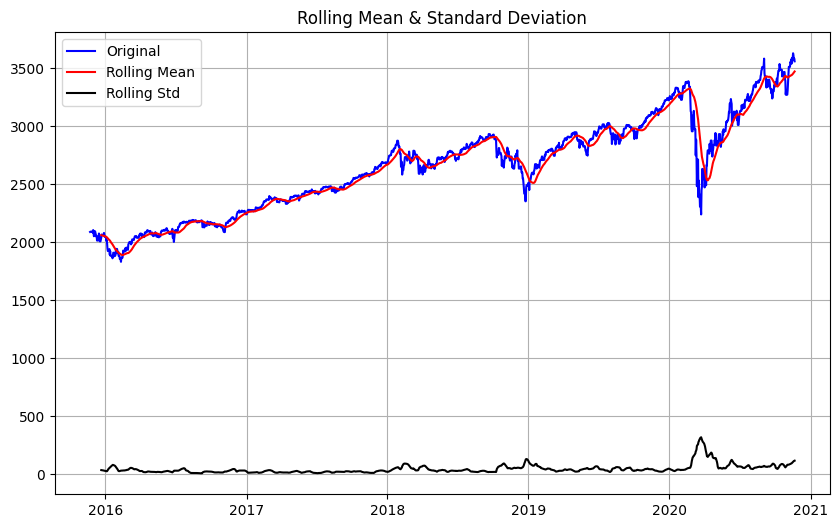

Results of Dickey-Fuller Test:
Test Statistic                   -0.870397
p-value                           0.797565
#Lags Used                       23.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


In [4]:


def evaluate_stationarity(timeseries, t=30):
    
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()

    # Perform Dickey-Fuller test
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'
    ])
    
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)

evaluate_stationarity(data['Close_Adj'])




**Insights**

p-value is 0.79, which is much higher than 0.05 the data is not stationary.

Test statistic (-0.87) is not lower than the critical values confirms non-stationarity.

This means the data likely has trends or patterns over time.


A **Log transformation** is used in time series analysis to stabilize variance and make patterns in the data more consistent over time. This is especially helpful when dealing with data that grows exponentially or shows increasing variability. After transformation, stationarity is evaluated to check if the statistical properties of the series—like mean and variance—remain constant over time. This is essential for many forecasting models. A combination of rolling statistics and the **Augmented Dickey-Fuller (ADF)** test is typically used. The rolling mean and standard deviation help visualize changes, while the ADF test provides statistical evidence for or against stationarity.

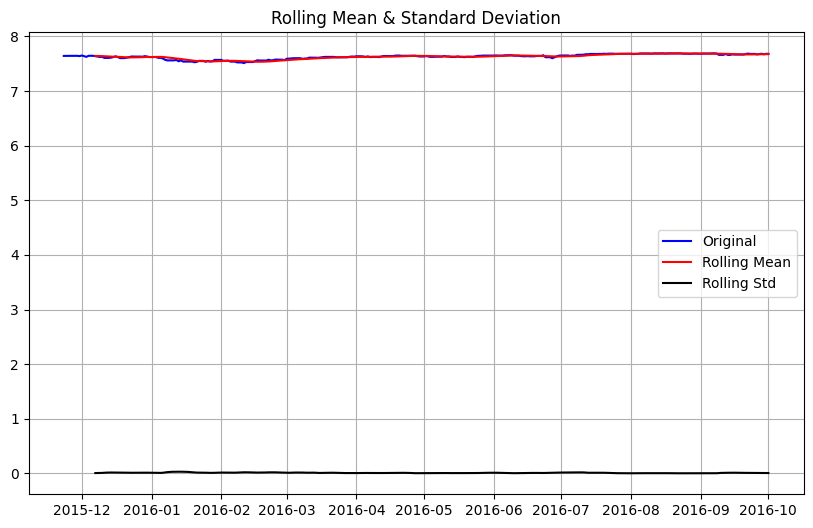

Results of Dickey-Fuller Test:
Test Statistic                  -1.139676
p-value                          0.698993
#Lags Used                       1.000000
Number of Observations Used    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64


In [5]:
data_log = np.log(data_train['Close_Adj'])
evaluate_stationarity(data_log, 15)


**Insights**

The p-value is 0.698993, which is much higher than 0.05, so the data is not stationary.

The test statistic is -1.139676, which is higher than all critical values, meaning we fail to reject the null hypothesis.

This indicates the time series still has trends or non-constant patterns over time.

Log transformation alone wasn't enough to make the data stationary; further steps like differencing are needed.

**Analyzing the stability of a time series** involves checking whether its key statistical properties—such as mean and variance—remain consistent over time. This concept is known as **stationarity**, and it is essential for many time series forecasting models, which assume the data does not change in unpredictable ways. To assess stationarity, analysts often use the **rolling mean** and **rolling standard deviation**, which are calculated over a moving time window (e.g., 15 days). The **rolling mean** shows how the average value changes over time, while the **rolling standard deviation** reflects the variability or spread of the data. If these rolling statistics remain relatively constant, it suggests that the time series is stationary and suitable for reliable modeling.


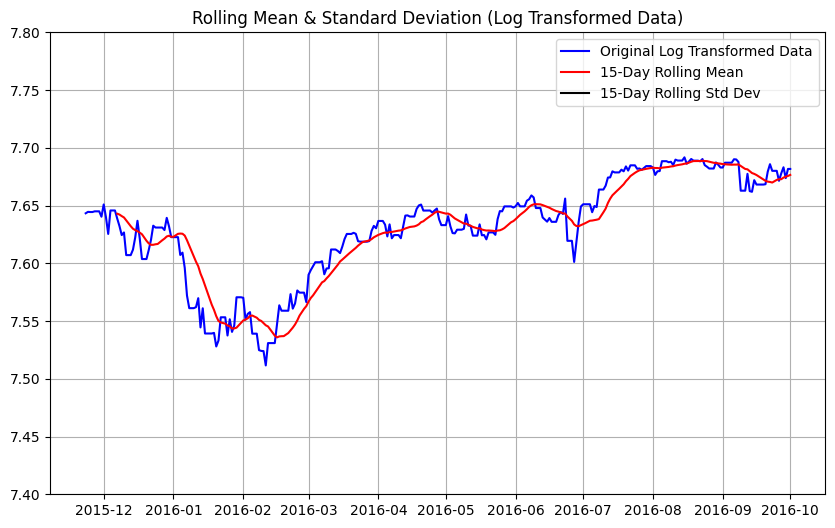

In [6]:

data_log = np.log(data_train['Close_Adj'])

rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()

plt.figure(figsize=(10, 6))
plt.plot(data_log, color='blue', label='Original Log Transformed Data')
plt.plot(rolmean, color='red', label='15-Day Rolling Mean')
plt.plot(rolstd, color='black', label='15-Day Rolling Std Dev')
plt.legend(loc='best')
plt.ylim([7.4, 7.8])  
plt.title('Rolling Mean & Standard Deviation (Log Transformed Data)')
plt.grid(True)
plt.show()


**Insights**

The log-transformed data (blue line) still shows a clear upward trend over time.

The red line (rolling mean) is not flat it follows the same trend, indicating non-stationarity.

The black line (rolling standard deviation) also varies, suggesting changing volatility over time.

Since both the mean and standard deviation are not constant, the time series is still not stationary even after log transformation.

A **square root transformation** is used in time series analysis to reduce the impact of larger values and stabilize variance, especially when dealing with positively skewed data. This transformation is less aggressive than a log transformation but still effective in making the data more uniform over time. After applying the transformation, stationarity is evaluated using rolling statistics and the Augmented Dickey-Fuller test. This helps determine whether the transformed series has constant mean and variance, which is a key requirement for many time series forecasting models.

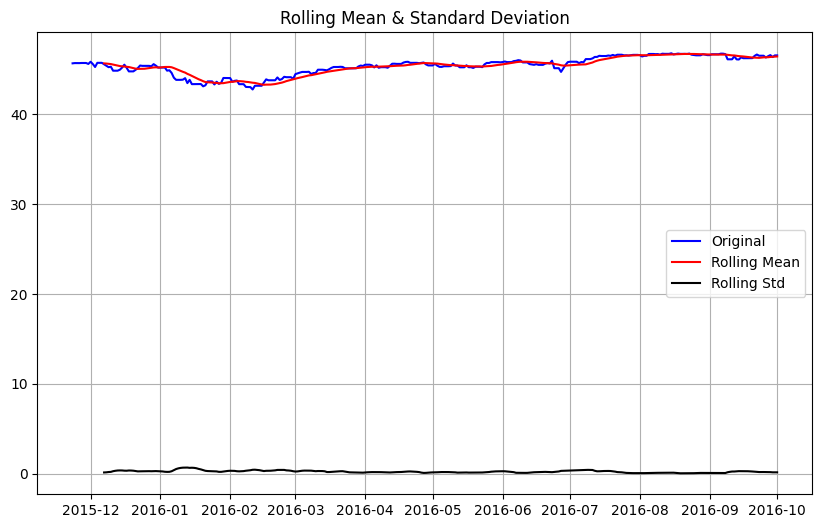

Results of Dickey-Fuller Test:
Test Statistic                  -1.128943
p-value                          0.703393
#Lags Used                       1.000000
Number of Observations Used    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64


In [7]:
data_sqrt = np.sqrt(data_train['Close_Adj'])
evaluate_stationarity(data_sqrt, 15)

**Insights**

The p-values in all three tests are significantly greater than 0.05, indicating that the null hypothesis of non-stationarity cannot be rejected.

The test statistics in each case are less negative than the critical values at 1%, 5%, and 10%, further confirming non-stationarity.

Rolling mean and standard deviation likely show trends or variation over time, consistent with a non-stationary time series.

Log transformation applied in the second and third tests did not significantly improve stationarity.

**Moving average smoothing** is a technique used in time series analysis to reduce short-term fluctuations and highlight longer-term trends or cycles in the data. It works by averaging the data points within a fixed-size window (in this case, 15 days) and moving that window across the series. This helps smooth out noise and makes it easier to observe the underlying pattern or trend. When applied to log-transformed data, it can further enhance stability and clarity, especially in datasets with high variability. This technique is commonly used as a preliminary step before modeling or deeper analysis.

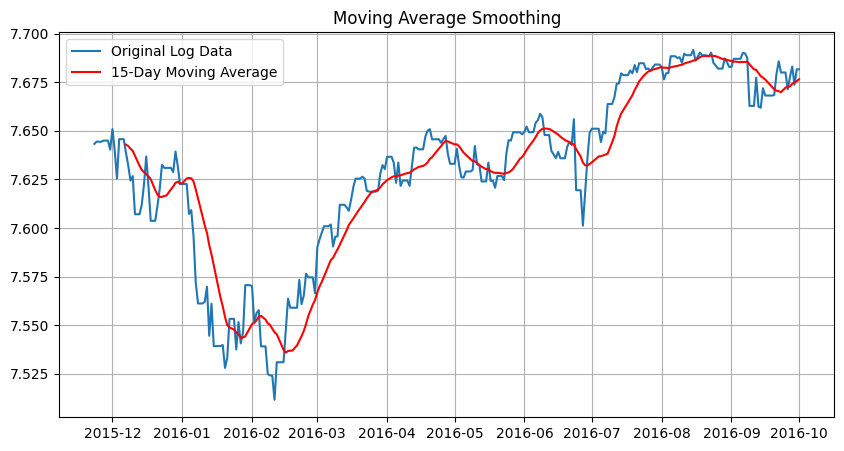

In [8]:
moving_avg = data_log.rolling(window=15).mean()
plt.figure(figsize=(10, 5))
plt.plot(data_log, label='Original Log Data')
plt.plot(moving_avg, color='red', label='15-Day Moving Average')
plt.legend(loc='best')
plt.title('Moving Average Smoothing')
plt.grid(True)
plt.show()


**Insights**

The original log-transformed data (blue line) shows daily fluctuations in the stock prices.

The 15-day moving average (red line) smooths out short-term variations, making the overall trend clearer.

Around early 2016, there is a noticeable dip in the trend, followed by a steady recovery.

The smoothed red line closely follows the direction of the original data, indicating it’s capturing the underlying trend effectively.

**To prepare our time series data for forecasting**, we need to ensure it is stationary — meaning its statistical properties like mean and variance remain constant over time. However, real-world stock price data often contains trends that make it non-stationary. In this step, we applied a log transformation to stabilize variance and then used a 15-day moving average to estimate the underlying trend in the data. By subtracting this moving average from the log-transformed series, we removed the trend component and obtained a detrended or trendless series. This process helps us focus on the short-term fluctuations in the data, making it more suitable for time series models like **ARIMA** that rely on stationarity

In [9]:
# Calculate 15-day moving average
moving_avg = data_log.rolling(window=15).mean()

# Subtract the moving average from the log-transformed data to remove trend
data_log_moving_avg_diff = data_log - moving_avg

# Display the first 15 values of the trendless (detrended) time series
data_log_moving_avg_diff.head(15)


Date
2015-11-23         NaN
2015-11-24         NaN
2015-11-25         NaN
2015-11-26         NaN
2015-11-27         NaN
2015-11-28         NaN
2015-11-29         NaN
2015-11-30         NaN
2015-12-01         NaN
2015-12-02         NaN
2015-12-03         NaN
2015-12-04         NaN
2015-12-05         NaN
2015-12-06         NaN
2015-12-07   -0.004215
Name: Close_Adj, dtype: float64

**Insights**

A 15-day moving average was applied to the log-transformed stock prices to smooth out trends.

This moving average captures the general direction of the data over time.

By subtracting the moving average from the original log data, we removed the trend component.

This results in a detrended (or trendless) time series, helping make the data more stationary for forecasting models.

**Removing Null Values**

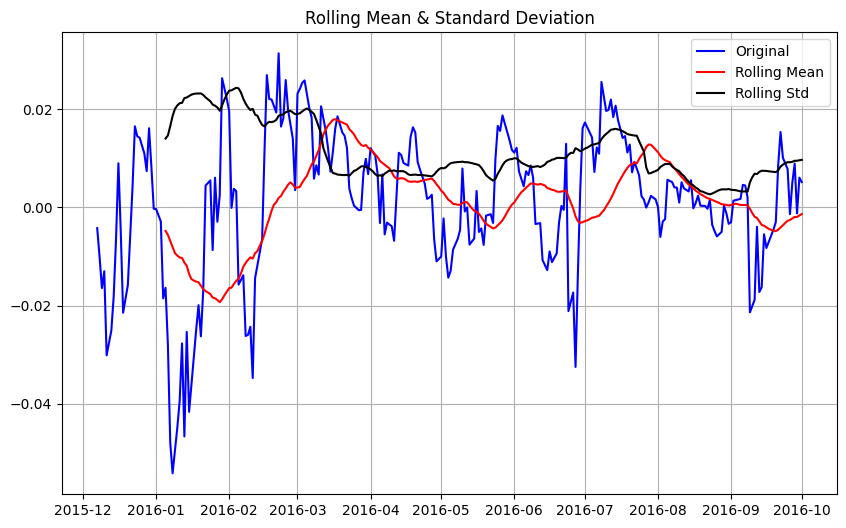

Results of Dickey-Fuller Test:
Test Statistic                  -4.515513
p-value                          0.000184
#Lags Used                       3.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


In [10]:
# Drop missing values created by the moving average operation
data_log_moving_avg_diff.dropna(inplace=True)

# Evaluate if the detrended data is stationary
evaluate_stationarity(data_log_moving_avg_diff)


**Insights**

The p-value is 0.000184, which is much less than 0.05, so we reject the null hypothesis — this means the series is now stationary.

The test statistic is -4.515513, which is lower (more negative) than all the critical values at 1%, 5%, and 10% confidence levels, confirming strong evidence of stationarity.

The data no longer has a significant trend or varying mean, making it suitable for time series forecasting models like ARIMA.

**Exponentially Weighted Moving Average (EWMA)** is a technique used to smooth time series data by giving more importance to recent observations while gradually decreasing the weight of older data. Unlike simple moving averages that treat all past values equally, EWMA applies exponentially decreasing weights, making it more responsive to recent changes or trends. This is especially useful for identifying short-term patterns and removing noise while preserving the overall structure of the data.


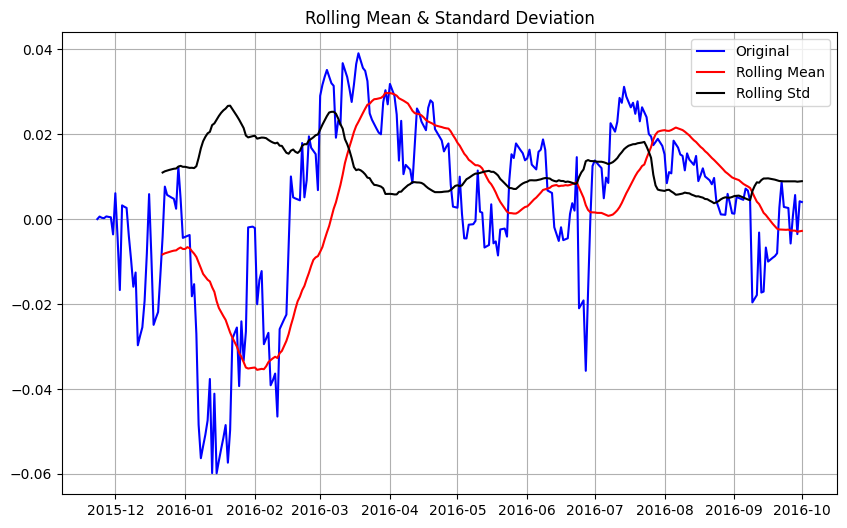

Results of Dickey-Fuller Test:
Test Statistic                  -2.815611
p-value                          0.056078
#Lags Used                       1.000000
Number of Observations Used    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64


In [11]:
# Apply exponentially weighted moving average (EWMA) with a halflife of 15
expweighted_avg = data_log.ewm(halflife=15).mean()

# Subtract EWMA from the original log-transformed data to remove trend
data_log_ewma_diff = data_log - expweighted_avg

# Evaluate if the result is stationary
evaluate_stationarity(data_log_ewma_diff)


**Insights**

The p-value is 0.056, which is slightly above 0.05, meaning we fail to strongly reject the null hypothesis — the data is not clearly stationary.

The test statistic (-2.81) is below the 10% critical value (-2.57) but above the 5% value (-2.87), indicating weak evidence of stationarity.

The series shows some signs of stationarity, but it's not strong enough for reliable time series modeling.

Further transformation or differencing might be needed to make the series fully stationary.

**First-order differencing** is a simple technique used in time series analysis to remove trends and make the data stationary. It works by subtracting each data point from the one that comes before it, effectively capturing the change between time steps instead of the actual values. This helps stabilize the mean of the series over time, which is essential for building reliable forecasting models like ARIMA that assume the data has constant statistical properties.


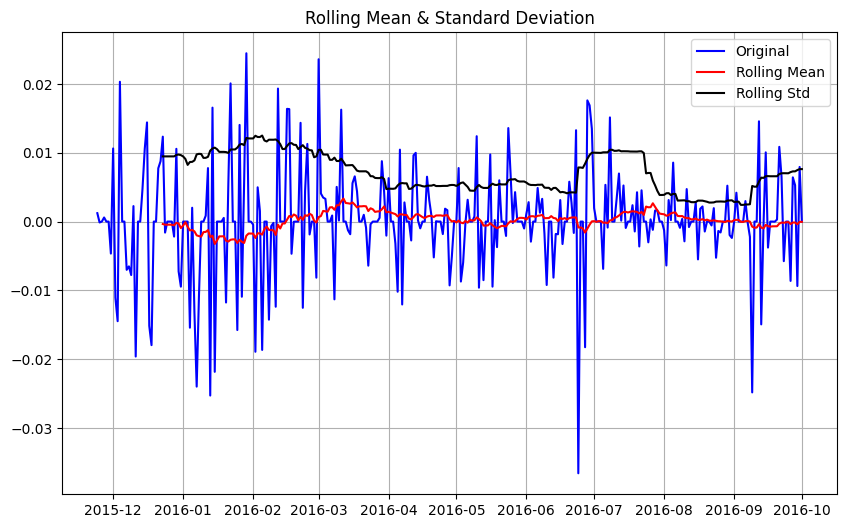

Results of Dickey-Fuller Test:
Test Statistic                 -19.640257
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64


In [12]:
# Calculate the difference between consecutive values (first-order differencing)
data_log_diff = data_log - data_log.shift()

# Remove any resulting NaN values
data_log_diff.dropna(inplace=True)

# Check if the differenced series is now stationary
evaluate_stationarity(data_log_diff)


**Insights**

The test statistic is -19.64, which is much lower than all the critical values at 1%, 5%, and 10% significance levels — this strongly suggests the series is stationary.

The p-value is 0.000000, which is far below 0.05, so we confidently reject the null hypothesis of non-stationarity.

This confirms that after applying first order differencing, your time series has become stationary.

The series is now suitable for building forecasting models like ARIMA, which require stationarity.

**Time Series Decomposition** is a technique used to break down a time series dataset into its individual components to better understand and analyze its underlying patterns. Specifically, it separates the data into three main parts: trend, seasonality, and residual (or noise). The trend component reflects the long-term progression of the data, showing upward or downward movement over time. The seasonal component captures repeating patterns or cycles at fixed intervals, such as daily, monthly, or yearly effects. The residual (or irregular) component represents the random fluctuations that cannot be explained by trend or seasonality. Decomposition helps analysts and data scientists better interpret the behavior of time series data, detect anomalies, and prepare the data for forecasting models that often require stationarity.

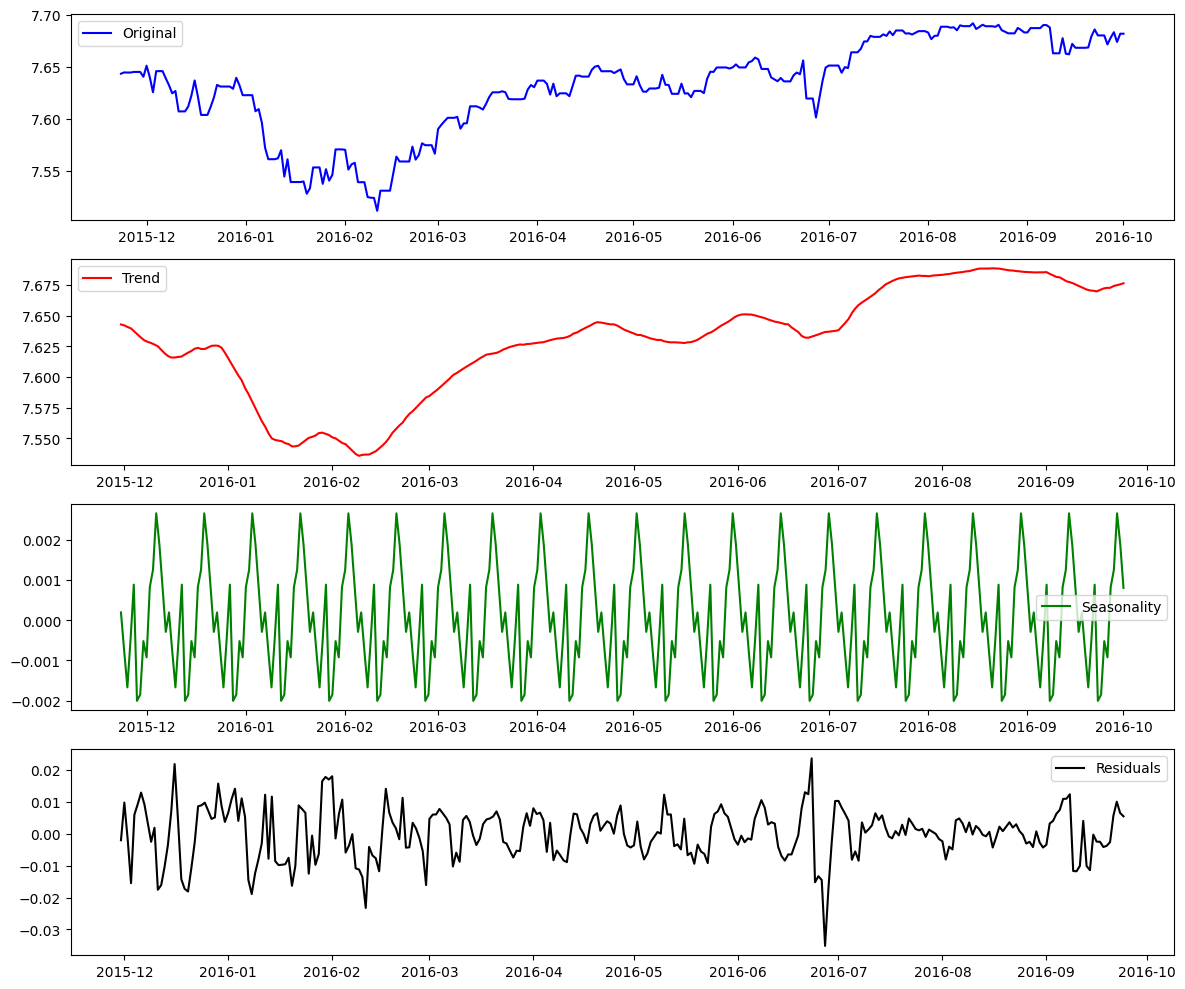

In [13]:

# Decompose the log-transformed series with a period of 15
decomposition = seasonal_decompose(data_log, period=15)  

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(data_log, label='Original', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='black')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


**1. Original Series**

The blue line represents the original data, showing fluctuations with noticeable peaks and troughs over time.

**2. Trend**

The red trend line indicates a general decline in values early on, followed by a gradual stabilization near the end of the period.

**3. Seasonality**

The green plot highlights a consistent seasonal pattern, reflecting regular fluctuations within specific intervals.

**4. Residuals**

The black residuals plot displays random variations around zero, suggesting that the model captures most of the structure in the data without significant bias.

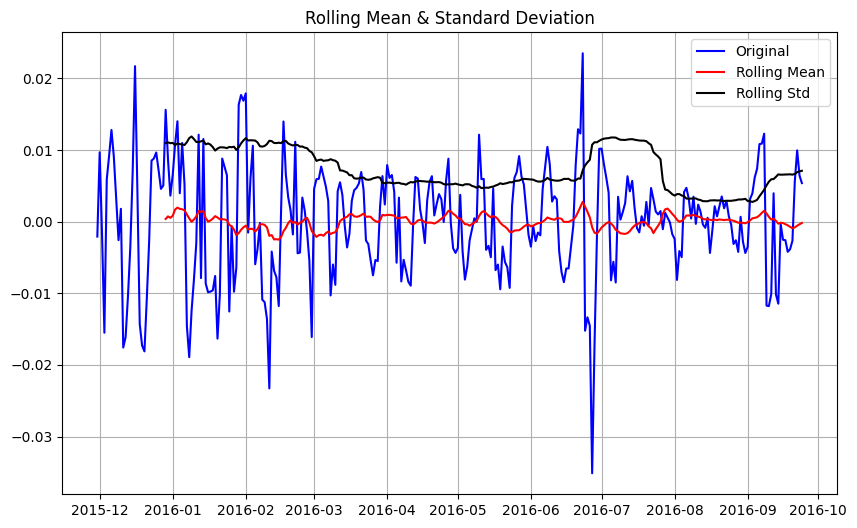

Results of Dickey-Fuller Test:
Test Statistic                -7.082173e+00
p-value                        4.635998e-10
#Lags Used                     1.000000e+01
Number of Observations Used    2.890000e+02
Critical Value (1%)           -3.453182e+00
Critical Value (5%)           -2.871593e+00
Critical Value (10%)          -2.572127e+00
dtype: float64


In [14]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)


**The Durbin-Watson statistic** tests whether residuals (errors) from a regression or time series model are independent specifically, it checks for first-order autocorrelation (i.e., whether errors are correlated with their immediate past values).

In [15]:
sm.stats.durbin_watson(data_log_diff)


2.2170173136324225

**Insights**

Durbin-Watson value of 2.217 indicates no significant autocorrelation.

Residuals appear random and independent.

Differencing or decomposition was successful.

Data is suitable for time series modeling (e.g., ARIMA).

Slight negative autocorrelation is negligible.

No further transformation is likely needed.

**ARIMA (AutoRegressive Integrated Moving Average)** is a popular statistical method used for forecasting time series data by combining autoregression (AR), differencing (I), and moving average (MA). **The ARIMA(2,1,0)** model specifically uses two previous values to predict the current one, applies first-order differencing to make the data stationary, and does not include any moving average component. It is effective for modeling data with trends but limited random noise.


e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


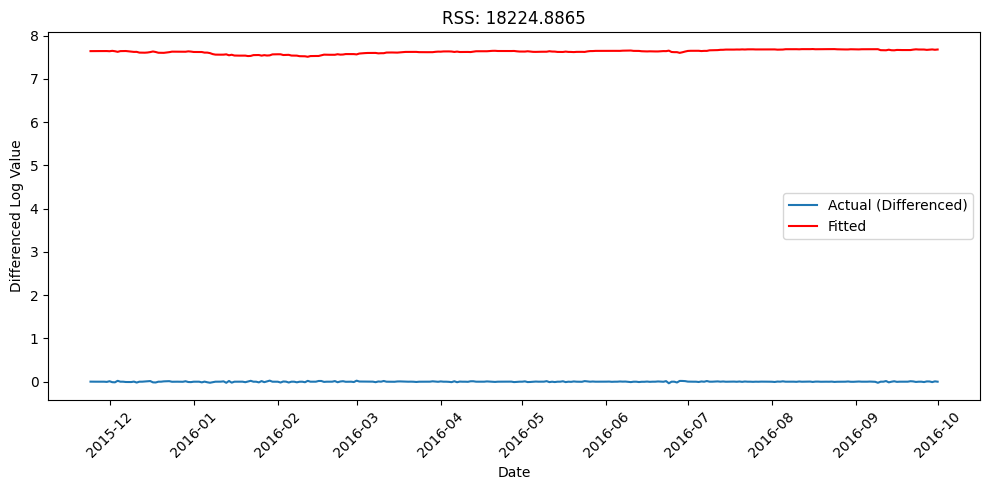

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assume data_log is your log-transformed time series
# and data_log_diff is the first-order differenced version

# Step 1: Fit ARIMA(2,1,0) model
model = ARIMA(data_log, order=(2, 1, 0))
results_AR_210 = model.fit()

# Step 2: Get fitted values and align with actual differenced data
fitted = results_AR_210.fittedvalues             # Model predictions
actual = data_log_diff.reindex(fitted.index)     # Align actual values

# Step 3: Drop any rows with NaN (from index mismatch)
combined = pd.concat([fitted, actual], axis=1).dropna()
fitted_aligned = combined.iloc[:, 0]
actual_aligned = combined.iloc[:, 1]

# Step 4: Calculate RSS
rss = ((fitted_aligned - actual_aligned) ** 2).sum()

# Step 5: Plot actual vs fitted
plt.figure(figsize=(10, 5))
plt.plot(actual_aligned, label='Actual (Differenced)')
plt.plot(fitted_aligned, color='red', label='Fitted')
plt.title('RSS: %.4f' % rss)
plt.xlabel('Date')
plt.ylabel('Differenced Log Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Insights**

Both lines are nearly flat, indicating a low variability in the differenced log values over the specified time period.
The fitted line closely follows the actual line, suggesting a good fit.

Overall, the analysis suggests that the model is reasonably effective in capturing the trend of the data, though the specific context of the data and modeling approach would provide additional insights.

An RSS of 18224.8865 indicates the model has a moderate error; further tuning or comparison with other ARIMA configurations may improve the fit.

**ARIMA (AutoRegressive Integrated Moving Average)** is a widely used model for analyzing and forecasting time series data. The **ARIMA(0,1,1) model** applies first-order differencing to make the data stationary and uses one past error term (MA part) to predict future values, without relying on past values themselves (AR part). This model is well-suited for time series with short-term shocks or noise but no strong autoregressive patterns.


e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


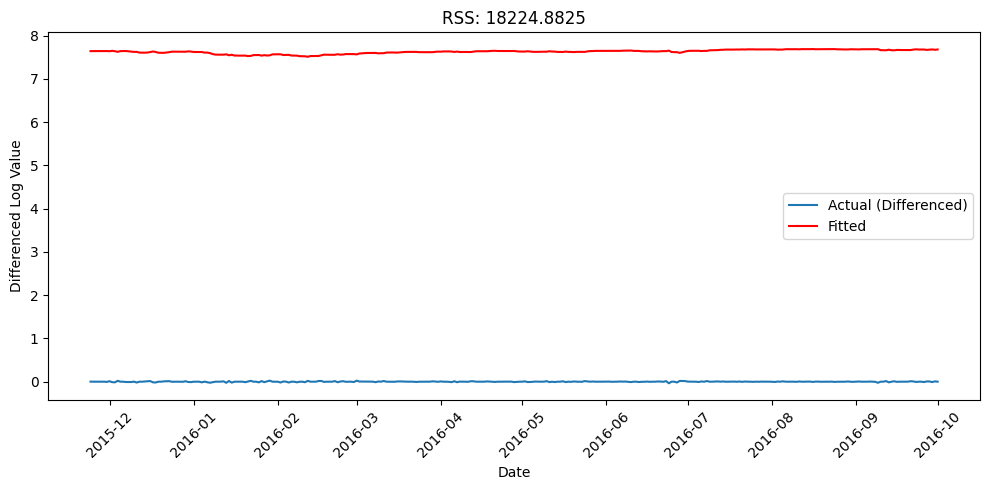

In [17]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Fit the MA(1) model (ARIMA(0,1,1))
model = ARIMA(data_log, order=(0, 1, 1))
results_MA_011 = model.fit()

# Step 2: Align fitted values with actual differenced log data
fitted = results_MA_011.fittedvalues
actual = data_log_diff.reindex(fitted.index)

# Step 3: Drop any NaNs
combined = pd.concat([fitted, actual], axis=1).dropna()
fitted_aligned = combined.iloc[:, 0]
actual_aligned = combined.iloc[:, 1]

# Step 4: Calculate RSS
rss = ((fitted_aligned - actual_aligned) ** 2).sum()

# Step 5: Plot
plt.figure(figsize=(10, 5))
plt.plot(actual_aligned, label='Actual (Differenced)')
plt.plot(fitted_aligned, color='red', label='Fitted')
plt.title('RSS: %.4f' % rss)
plt.xlabel('Date')
plt.ylabel('Differenced Log Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Insights**

Both lines are nearly flat, indicating a low variability in the differenced log values over the specified time period.
The fitted line closely follows the actual line, suggesting a good fit.

Overall, the analysis suggests that the model is reasonably effective in capturing the trend of the data, though the specific context of the data and modeling approach would provide additional insights.

An RSS of 18224.8825 indicates the model has a moderate error; further tuning or comparison with other ARIMA configurations may improve the fit.

**ARIMA (AutoRegressive Integrated Moving Average)** is a forecasting technique that models time series data by combining past values, differencing, and past error terms. The **ARIMA(1,1,1)** model includes one autoregressive term (using one past value), first-order differencing (to make the data stationary), and one moving average term (using one past error). This model balances the influence of recent trends and recent shocks, making it effective for time series data with both autocorrelation and random fluctuations.

e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\New folder (2)\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


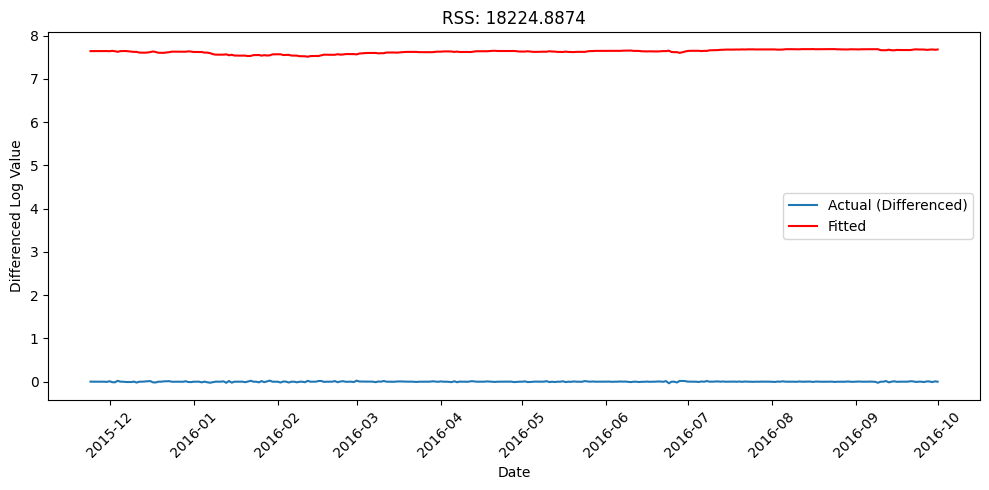

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Fit the ARIMA(1,1,1) model
model = ARIMA(data_log, order=(1, 1, 1))
results_ARIMA_111 = model.fit()

# Align fitted values and actual differenced values
fitted = results_ARIMA_111.fittedvalues
actual = data_log_diff.reindex(fitted.index)

# Drop NaNs
combined = pd.concat([fitted, actual], axis=1).dropna()
fitted_aligned = combined.iloc[:, 0]
actual_aligned = combined.iloc[:, 1]

# Calculate RSS
rss = ((fitted_aligned - actual_aligned) ** 2).sum()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(actual_aligned, label='Actual (Differenced)')
plt.plot(fitted_aligned, color='red', label='Fitted')
plt.title('RSS: %.4f' % rss)
plt.xlabel('Date')
plt.ylabel('Differenced Log Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Insights**

Both lines are nearly flat, indicating a low variability in the differenced log values over the specified time period.
The fitted line closely follows the actual line, suggesting a good fit.

Overall, the analysis suggests that the model is reasonably effective in capturing the trend of the data, though the specific context of the data and modeling approach would provide additional insights.

An RSS of 18224.8874 indicates the model has a moderate error; further tuning or comparison with other ARIMA configurations may improve the fit.

This line creates a Pandas Series from the fitted values of the ARIMA model, which represent predictions on the differenced data. Since ARIMA is trained on stationary (differenced) data, these predictions reflect changes, not absolute values. By copying the fitted values into a new Series, we preserve the original model output and prepare the data for further transformation, such as cumulative summation or conversion back to the original scale. This is a crucial step in reconstructing the forecasted values for real-world interpretation.

In [19]:
predictions_ARIMA_diff = pd.Series(results_ARIMA_111.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2015-11-23    0.000000
2015-11-24    7.643286
2015-11-25    7.644375
2015-11-26    7.644389
2015-11-27    7.644379
dtype: float64


**Insights**

First value is 0 — likely a baseline.

Slight increase in values over time.

Data is in log-transformed scale.

Indicates a stable, low-volatility trend.

Suggests small positive movement in original series.

After fitting an ARIMA model on differenced data, the predicted values represent changes rather than actual values. To convert these predictions back to their original scale, we take the **cumulative sum (cumsum)** of the differenced predictions. This step reverses the differencing transformation applied earlier in the ARIMA model. The result is a sequence that approximates the log-transformed original data, enabling further steps to return to the true scale of the original series.

In [20]:
# Calculate cumulative sum of the differenced predictions
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# Display the first few values
print(predictions_ARIMA_diff_cumsum.head())


Date
2015-11-23     0.000000
2015-11-24     7.643286
2015-11-25    15.287662
2015-11-26    22.932050
2015-11-27    30.576429
dtype: float64


**Insights**

Values increase steadily each day.

Shows a strong upward trend.

In log-transformed scale.

Predictions suggest consistent growth.

Used to rebuild original forecast.

**The Akaike Information Criterion (AIC)** is a metric used to compare different statistical models. It balances the model's goodness of fit with its complexity by penalizing models that use too many parameters. In time series forecasting, a lower AIC value suggests a model that better explains the data with fewer assumptions. When comparing ARIMA models with different (p, d, q) values, the one with the lowest AIC is typically considered the best choice.

In [21]:
print(results_ARIMA_111.aic)


-2161.9516614795493


**Insights**

AIC value is -2161.95, which is quite low.

Indicates a very good model fit.

Suggests the model is both accurate and not overly complex.

Useful for comparing with other models lower AIC is better.

Time series forecasting often involves transforming data to make it stationary, commonly through differencing and log transformation. Differencing removes trends by focusing on changes between values, while log transformation stabilizes variance. To interpret model outputs, these transformations must be reversed differencing is undone using cumulative sums, and log-transformed values are later exponentiated. Accurate forecasting also relies on aligning time indices, ensuring predictions correspond to the correct time points. These foundational concepts are crucial for building, interpreting, and reconstructing reliable forecasts from time series models.

In [22]:
# Step 1: Create a Series initialized with the first log value
predictions_ARIMA_log = pd.Series(data_log.iloc[0], index=data_log.index)

# Step 2: Add the cumulative differenced predictions to it
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

# Step 3: Show the first few values
print(predictions_ARIMA_log.head())


Date
2015-11-23     7.643286
2015-11-24    15.286573
2015-11-25    22.930948
2015-11-26    30.575337
2015-11-27    38.219716
dtype: float64


**Insights**

Values increase steadily day by day.

Indicates a strong upward trend.

Data is likely in log scale.

Model predicts consistent growth over time.

Suggests low volatility and stable pattern.

**Mean Forecast Error (MFE)** tells us if the predictions are generally too high or too low by averaging the difference between predicted and actual values. **Mean Absolute Error (MAE)** gives the average size of the errors, without considering direction, showing how close the predictions are to actual values. **Root Mean Square Error (RMSE)** also measures prediction accuracy but gives more weight to larger errors, making it useful when big mistakes matter more.


e:\New folder (2)\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


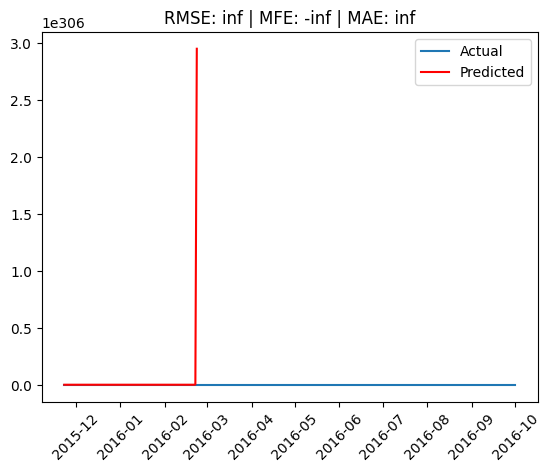

In [23]:
# Define error metric functions
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean(np.abs(y.sub(yhat)))  # Corrected MAE calculation

def rmse(y, yhat):
    return np.sqrt(np.mean((yhat - y) ** 2))

# Convert predictions back from log scale
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Plot actual and predicted values
plt.plot(data_train['Close_Adj'], label='Actual')
plt.plot(predictions_ARIMA, label='Predicted', color='red')
plt.xticks(rotation=45)
plt.title('RMSE: %.4f | MFE: %.4f | MAE: %.4f' % (
    rmse(data_train['Close_Adj'], predictions_ARIMA),
    mean_forecast_err(data_train['Close_Adj'], predictions_ARIMA),
    mean_absolute_err(data_train['Close_Adj'], predictions_ARIMA)
))
plt.legend()
plt.show()



**Insights**

The graph displays a time series with two lines: one for "Actual" values (blue) and the other for "Predicted" values (red).

The x-axis represents dates from December 2015 to October 2016.

There is a significant spike in the "Predicted" values around March 2016, but the rest of the data points are at or near zero.

The root mean square error (RMSE), mean forecast error (MFE), and mean absolute error (MAE) all indicate infinite values.

**Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** are tools used to understand the internal structure of a time series. ACF shows how current values relate to past values over various time lags, helping identify the "MA" (Moving Average) component. PACF shows the relationship between current and past values while controlling for the values in between, which helps identify the "AR" (Auto-Regressive) component. Together, ACF and PACF plots help determine suitable values for the ARIMA model parameters (p and q) by revealing significant spikes at specific lags.

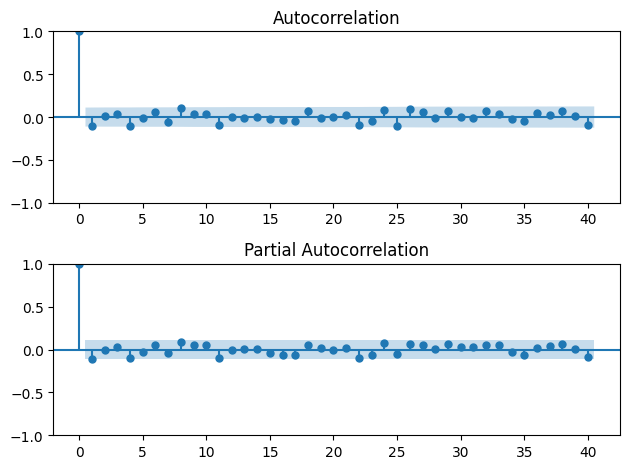

In [24]:
# Plot ACF and PACF to identify AR and MA terms
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)

ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

plt.tight_layout()
plt.show()


**Insights**

Low autocorrelation → The time series shows little correlation with its past values, suggesting minimal MA (Moving Average) effects.

Weak partial autocorrelation → Indicates a weak or no AR (Auto-Regressive) relationship with past lags.

Model simplicity → A simpler model like ARIMA(0,1,0) may suffice, as no strong lag patterns are detected.

Stationarity likely achieved → Differencing (d=1) might have effectively removed trends, making the series stationary.

Noise-dominated pattern → The series may behave more like random noise after differencing, with no strong lag structure to model.